# Imports

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import brentq, newton
import matplotlib.pyplot as plt
import pandas as pd

/Users/adamsmith/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Notes

**Dark Matter Model**

We start with a minimal dark matter model that includes a dark boson and a dark photon mediator. We may follow Ref [1](https://arxiv.org/abs/0812.2770v2) where a boson with repuslive self interactions is chosen. Ref [1](https://arxiv.org/abs/0812.2770v2) provides an equation of state that is used to solve the TOV eqations. Further, a speed of sound and a thermodynamic regime are required to study the growth of overdensities using linear pertubation theory. 

**Boson Star**

The dark matter boson with repulsive self inteaction in Ref [1](https://arxiv.org/abs/0812.2770v2) has scaling relations following the solutions to the TOV equation and a maximum mass and radius simialr to the Landau results with a scaling due to the ineraction strength. 

**Fragmentation**

Given a dark matter boson and photon, we want to use a Jeans analysis to calculate the fragmentation of a dark matter halo into minimal componenets, i.e. exotic compact object. Solving for the Jeans mass and using a bremsstrahlung cooling mechanism we want to find the typical size and abundance of boson stars following Ref [2](https://arxiv.org/abs/1812.07000).

# Dark matter model 

Equation of state for bososn is:

$$ p = y^2 n_b'^2 \;, \quad \text{and} \quad \epsilon = n_b' + y^2 n_b'^2$$

where $n_b'=n_b/m_b^3$. While for ineracting gas of bosons, 

$$ p = y^2 n_b'^2 + n_b'T \;, \quad \text{and} \quad \epsilon = 3/2n_b'T+ y n_b'^2 + mn_b' \quad .$$

For the speed of sound, requried to study growth of overdentities, we use, 

$$ $$

In [24]:
from sympy import symbols, solve, Eq, simplify

# Redefine symbols specifying positivity
n, T, y, m, P, e = symbols('n T y m P e', positive=True)

# Equations definition
eq_P = Eq(P, n*T + y*n**2)  # P equation
eq_e = ((3/2)*n*T + y*n**2 + m*n)  # Expression for e, not an equation

# Solve eq_P for n
n_solution = solve(eq_P, n)


e_substituted = eq_e.subs(n, n_solution[0])

# Simplify the expression (optional, for cleaner output)
e_simplified = simplify(e_substituted)

e_simplified


(T - sqrt(4*P*y + T**2))*(-2.0*T - 2*m - sqrt(4*P*y + T**2))/(4*y)

In [2]:
mb = 1 # mass of boson
y = 1 # interaction term 

In [25]:
class EOS:
    def __init__(self, P, params):
        self.P = P
        self.params = params
        self.eos_types = {
            'radiation':self.radiation_eos,
            'boson':self.boson_eos,
            'boson_temp':self.boson_temp_eos
        }
        
    def radiation_eos(self):
        w, _, _, _ = self.params
        return self.P / w

    def boson_eos(self):
        y, _, _, _ = self.params
        return np.sqrt(self.P/(y**2))+self.P
    
    def boson_temp_eos(self):
        y, n, m, T = self.params
        t1 = T - np.sqrt(4*self.P*y + T**2)
        t2 = -2*T - 2*m - np.sqrt(4*self.P*y + T**2)
        return (t1*t2)/(4*y)
    
    def get_eos(self, eos_type):
        if eos_type in self.eos_types:
            return self.eos_types[eos_type]()
        else:
            raise ValueError(f"Equation of state '{eos_type}' is not defined.")

In [26]:
eos = EOS(1, (2,3,2,1))

In [28]:
eos.get_eos('boson')

1.5

In [51]:
# tov equations for boson star in dimensionless form 
def TOV(r, y, params, eos_type='boson'):
    # Pressure and mass
    P, M = y
    
    # Equation of state for energy density
    eos = EOS(P, params)
    eps = eos.get_eos(eos_type)

    # Handle singularities
    r = max(r, 1e-6)
    M = max(M, 1e-10)
    
    # dpdr
    prefactor = -(M*eps)/r**2
    corr1 = (1 + (P/eps))
    corr2 = (1 + ((4*np.pi*(r**3)*P)/M))
    corr3 = (1 - ((2*M)/r))**-1
    
    dpdr = prefactor*corr1*corr2*corr3
    
    # dmdr
    dmdr = 4*np.pi*(r**2)*eps
    
    return [dpdr, dmdr]

In [57]:
r = 1
y = 10, 0
params = (1,2,1,1)

TOV(r, y, params, eos_type='boson_temp')

[-3022.506585801301, 176.5869523758477]

In [58]:
r_span = (1e-5,10) 

# initial conditions for pressure and mass
P0=1
M0=0
# tuple for args 
w=(y,)

initial_conditions = (P0,M0)
params = (1,1,1,1)

def pressure_condition(r, y):
    P, M = y
    return P

# condition to stop integration
pressure_condition.terminal = True  
pressure_condition.direction = -1  

def tov_ivp(r, y):
    return TOV(r, y, params, eos_type='boson_temp')

# solve the differential TOV equation
sol = solve_ivp(tov_ivp, r_span, initial_conditions, 
                method='RK45', 
                events=pressure_condition, 
                atol=1e-6, rtol=1e-9)

/var/folders/71/rd8s6g0x52sd1l6wnf9_z6_r0000gn/T/ipykernel_17881/444206098.py:17: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.P/(y**2))+self.P


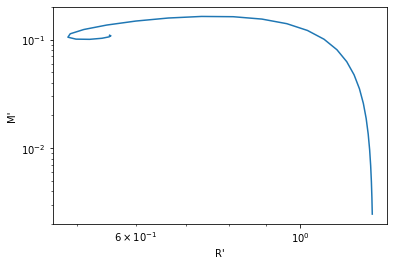

In [56]:
r_span = (1e-5,10)
interaction_strength = 1
params = (interaction_strength,1,1,1)

starting_pressure = 1e-6/interaction_strength # scales as p/y
initial_pressures =  starting_pressure*np.array([(2**n) for n in  range(30)]) # double every step

star = np.zeros((len(initial_pressures), 3)) # [M,P,R] for each initial pressure
    
for i, pi in enumerate(initial_pressures):
    # initial mass
    M0=0
    initial_conditions = [pi,M0]

    # solve the differential TOV equation
    sol = solve_ivp(tov_ivp, r_span, initial_conditions, 
                    method='RK45', events=pressure_condition,  
                    atol=1e-8, rtol=1e-8, dense_output=True)

    # Extracting results
    r_sol = sol.t
    p_sol = sol.y[0]
    M_sol = sol.y[1]

    # Extract the final radius, mass and pressure
    R = r_sol[-1]
    M = M_sol[-1]
    P = p_sol[-1]

    # save to array
    star[i] = [M, P, R]

# plot M, R
plt.loglog(star[:,2], star[:,0])
plt.xlabel("R'")
plt.ylabel("M'")
    
plt.show()

## Testing temperature

/var/folders/71/rd8s6g0x52sd1l6wnf9_z6_r0000gn/T/ipykernel_17881/444206098.py:21: RuntimeWarning: invalid value encountered in sqrt
  t1 = T - np.sqrt(4*self.P*y + T**2)
/var/folders/71/rd8s6g0x52sd1l6wnf9_z6_r0000gn/T/ipykernel_17881/444206098.py:22: RuntimeWarning: invalid value encountered in sqrt
  t2 = -2*T - 2*m - np.sqrt(4*self.P*y + T**2)


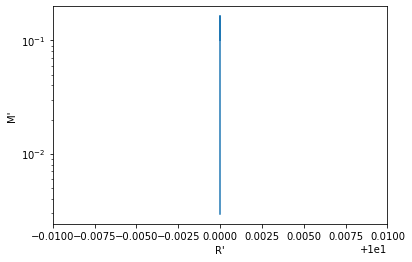

In [91]:
# r_span = (1e-5,10)
interaction_strength = 1

starting_pressure = 1e-6/interaction_strength # scales as p/y
initial_pressures =  starting_pressure*np.array([(2**n) for n in  range(30)]) # double every step

star = np.zeros((len(initial_pressures), 3)) # [M,P,R] for each initial pressure

temps = [1e-4]
for T in temps:
    for i, pi in enumerate(initial_pressures):
        # initial mass
        M0=0
        initial_conditions = [pi,M0]
        
        params = (interaction_strength,1e-1,1,T) # y,n,m,T

        # solve the differential TOV equation
        sol = solve_ivp(tov_ivp, r_span, initial_conditions, 
                        method='RK45', events=pressure_condition,  
                        atol=1e-8, rtol=1e-8, dense_output=True)

        # Extracting results
        r_sol = sol.t
        p_sol = sol.y[0]
        M_sol = sol.y[1]

        # Extract the final radius, mass and pressure
        R = r_sol[-1]
        M = M_sol[-1]
        P = p_sol[-1]

        # save to array
        star[i] = [M, P, R]

    # plot M, R
    plt.plot(star[:,2], star[:,0])
    plt.xlabel("R'")
    plt.ylabel("M'")
    plt.yscale('log')

    plt.xlim(9.99,10.01)
    plt.show()

In [73]:
# check EOS 
pressures = np.linspace(1e-2,100,num=100)
params = (1,1,1,1)

boson_list=[]
temp_list=[]

for p in pressures:
    eos = EOS(p, params)
    boson = eos.get_eos('boson')
    boson_list.append([p, boson])
    
    temp = eos.get_eos('boson_temp')
    temp_list.append([p, temp])

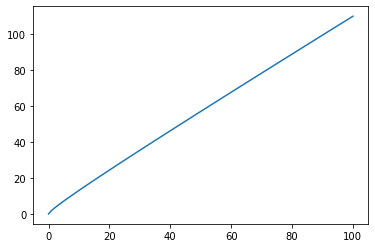

In [79]:
p = np.array(boson_list)[:,0]

plt.plot(p,np.array(boson_list)[:,1])

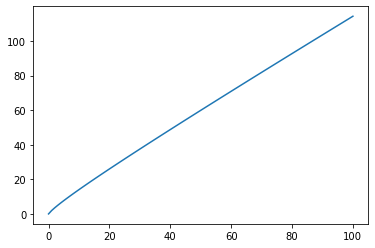

In [80]:
plt.plot(p,np.array(temp_list)[:,1])

In [87]:
np.array(boson_list)[:,1]

array([  0.11      ,   2.02995049,   3.45478068,   4.78355958,
         6.06246118,   7.30944438,   8.533737  ,   9.74082694,
        10.93429253,  12.11662063,  13.28962262,  14.4546664 ,
        15.61281495,  16.76491379,  17.91164857,  19.05358447,
        20.19119385,  21.32487636,  22.45497362,  23.58178046,
        24.70555336,  25.82651712,  26.94487009,  28.06078832,
        29.1744289 ,  30.28593275,  31.39542681,  32.50302594,
        33.60883446,  34.71294744,  35.81545184,  36.91642743,
        38.01594759,  39.11408001,  40.2108873 ,  41.3064275 ,
        42.40075451,  43.49391855,  44.58596643,  45.67694193,
        46.76688603,  47.85583716,  48.94383144,  50.03090282,
        51.11708332,  52.20240313,  53.28689079,  54.37057327,
        55.45347614,  56.53562364,  57.61703876,  58.69774338,
        59.77775827,  60.85710325,  61.93579718,  63.01385806,
        64.09130308,  65.16814865,  66.24441049,  67.32010363,
        68.39524245,  69.46984076,  70.5439118 ,  71.61

In [88]:
np.array(temp_list)[:,1]

array([2.48529270e-02, 1.96041415e+00, 3.54495033e+00, 5.01075357e+00,
       6.41046620e+00, 7.76651559e+00, 9.09094153e+00, 1.03910959e+01,
       1.16718587e+01, 1.29366655e+01, 1.41880431e+01, 1.54279146e+01,
       1.66577836e+01, 1.78788523e+01, 1.90920998e+01, 2.02983359e+01,
       2.14982399e+01, 2.26923877e+01, 2.38812732e+01, 2.50653231e+01,
       2.62449097e+01, 2.74203597e+01, 2.85919618e+01, 2.97599725e+01,
       3.09246212e+01, 3.20861138e+01, 3.32446359e+01, 3.44003558e+01,
       3.55534262e+01, 3.67039868e+01, 3.78521650e+01, 3.89980781e+01,
       4.01418339e+01, 4.12835321e+01, 4.24232647e+01, 4.35611172e+01,
       4.46971692e+01, 4.58314944e+01, 4.69641622e+01, 4.80952369e+01,
       4.92247791e+01, 5.03528457e+01, 5.14794898e+01, 5.26047617e+01,
       5.37287088e+01, 5.48513756e+01, 5.59728045e+01, 5.70930353e+01,
       5.82121058e+01, 5.93300520e+01, 6.04469079e+01, 6.15627059e+01,
       6.26774768e+01, 6.37912499e+01, 6.49040533e+01, 6.60159136e+01,
      

## Speed of sound and Jeans mass

To get the speed of sound we may use the relation

$$ c_s^2 = \frac{dp}{de} \quad . $$

For and ideal gas the speed of sound is, 

$$ c_s = \sqrt{\gamma \frac{T}{m}} \quad , $$

where $\gamma$ is 5/3 for adiabatic for monotonic gas. 

For an interacting boson gas with the pressure and energy density, 

$$ p = yn^2 , \quad e = mn + yn^2 \quad , $$

from which we get, 

$$ c_s = \sqrt{\frac{2yn}{m+2yn}} .$$

If we add temperature terms to the pressure and energy density so that, 


$$ p = yn^2 + nT , \quad e = mn + yn^2 + \frac{3}{2}nT \quad , $$

speed of sound is a but more complicated becasue e depends on n and T, and Im not sure how n and T relate for equal entropy. 

<!-- $$ c_s = \sqrt{\frac{2yn+T}{m+2yn+3/2T}} .$$ -->



## Cooling mechanism 

The interacting boson dark matter cools via Bremstralung radiation, 

$$ \Lambda_{BS} = \frac{32\alpha^3\rho_B T}{\sqrt{\pi}m_B^4}\sqrt{\frac{T}{m_B}}e^{\frac{-\beta}{T}} $$

where $\alpha$ is analagous to the fine structure constant in our model, and $\beta=m_\gamma/m_B$ where $m_\gamma/m_B << 1$. 

In [124]:
T = np.logspace(-8,0, num=100)
alpha = 1
mb = 1
rhob = 1

def bremsstrahlung(T, beta=1e-2):
    prefactor = (32 * (alpha**3) * rhob * T) / (np.sqrt(np.pi) * mb**4)
    second = np.sqrt(T/mb)
    supression = np.exp(-beta/T)
    return prefactor * second * supression

In [125]:
c1 = np.array([bremsstrahlung(t) for t in T])
c2 = np.array([bremsstrahlung(t,beta=1e-4) for t in T])

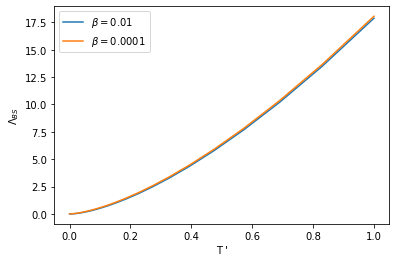

In [126]:
plt.plot(T, c1, label=r"$\beta = 0.01$")
plt.plot(T, c2, label=r"$\beta = 0.0001$")
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("T '")
plt.ylabel(r"$\Lambda_{BS}$")
plt.legend()
plt.show()

## Jeans mass

Equation for Jeans mass:

$$ m_J = \frac{\pi}{6}c_s^3 \left(\frac{\pi}{G}\right)^{3/2} \left(\frac{1}{\rho}\right)^{1/2} $$


In [109]:
y = 1
mb = 1
rho = 1
G = 1
n = np.logspace(-8,0,num=1000)

def sound_speed(n):
    return np.sqrt( (2*y*n) / (mb + 2*y*n) )

def jeans_mass(n):
    cs = sound_speed(n)
    return (np.pi/6) * (cs**3) * ((np.pi/G)**(3/2)) * ((1/rho)**(1/2))

In [110]:
jeans_mass_n = np.array( [[ni, jeans_mass(ni)] for ni in n] )

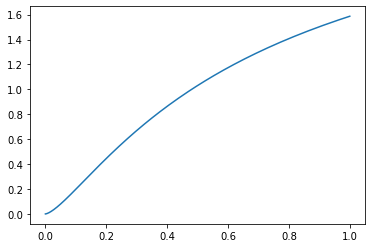

In [113]:
plt.plot(jeans_mass_n[:,0], jeans_mass_n[:,1])

In [103]:
y = 1
mb = 1
rho = 1
G = 1
T = np.logspace(-8,0,num=1000)

def sound_speed_ideal(T):
    gamma = 5/3
    return np.sqrt(gamma* (T/mb))

def jeans_mass(T):
    cs = sound_speed_ideal(T)
    return (np.pi/6) * (cs**3) * ((np.pi/G)**(3/2)) * ((1/rho)**(1/2))

In [104]:
jeans_mass_T = np.array( [[Ti, jeans_mass(Ti)] for Ti in T] )

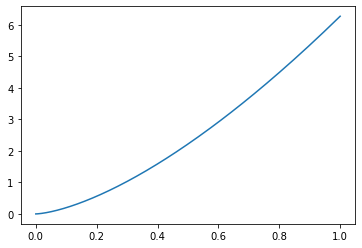

In [105]:
plt.plot(jeans_mass_T[:,0], jeans_mass_T[:,1])

In [114]:
cs_interacting = np.array( [[ni, sound_speed(ni)] for ni in n] )
cs_ideal = np.array( [[Ti, sound_speed_ideal(Ti)] for Ti in T] )

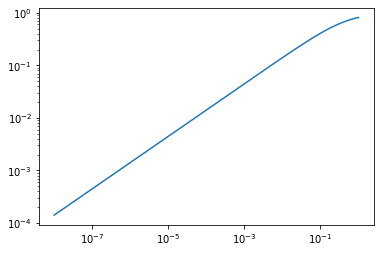

In [120]:
plt.loglog(cs_interacting[:,0], cs_interacting[:,1])

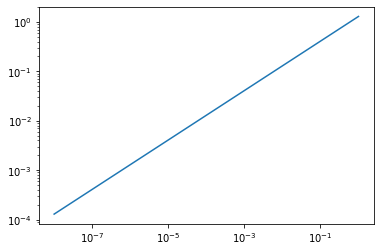

In [119]:
plt.loglog(cs_ideal[:,0], cs_ideal[:,1])

## Jeans mass contours

The Jeans mass for an ideal gas with speed of sound $c_s$ stated above looks like, 

$$ m_J = \frac{\pi}{6}\left(\sqrt{\gamma \frac{T}{m_B}} \right)^3 \left(\frac{\pi}{G}\right)^{3/2} \left(\frac{m_B}{n}\right)^{1/2} $$

where $\rho = n/m_B$ is used here. We want to plot contours of constant jeans mass.

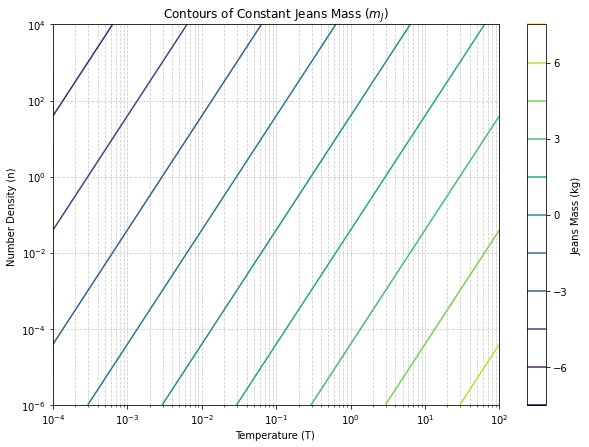

In [159]:
gamma = 5/3
mb = 1
G = 1

ni = np.logspace(-6,4,num=1000)
Ti = np.logspace(-4,2,num=1000)

T, n = np.meshgrid(Ti, ni)

m_J = (np.pi / 6) * (np.sqrt(gamma * T / mb))**3 * (np.pi / G)**(3/2) * (mb / n)**(1/2)

log_m_J = np.log10(m_J)

# Plotting
plt.figure(figsize=(10, 7))
contours = plt.contour(T, n, log_m_J, levels=10, cmap='viridis')
# contours = plt.contour(T, n, m_J, levels=np.logspace(np.log10(np.min(m_J)), np.log10(np.max(m_J)), 100))
# plt.clabel(contours, inline=False, fontsize=8, fmt='%1.1e')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Number Density (n) ')
plt.xlabel('Temperature (T) ')
plt.title('Contours of Constant Jeans Mass ($m_J$)')
plt.colorbar(contours, label='Jeans Mass (kg)')
plt.grid(True, which="both", ls="--", color='0.8')
plt.show()

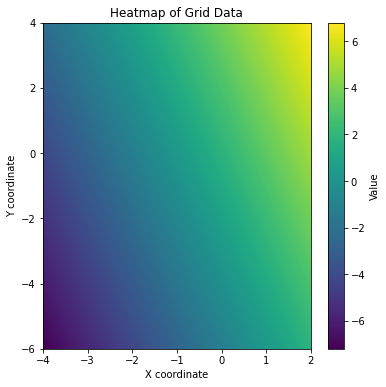

In [167]:
plt.figure(figsize=(6, 6))
plt.imshow(log_m_J, cmap='viridis', aspect='auto', extent=[-4, 2, -6, 4])
plt.colorbar(label='Value')
plt.title('Heatmap of Grid Data')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()

In [166]:
np.min(n)

1e-06